**Upload Zip File Dataset**

In [1]:
from google.colab import files
import zipfile
import os

uploaded = files.upload()
zip_path = list(uploaded.keys())[0]

Saving animal_dataset.zip to animal_dataset.zip


**Unzip Dataset File**

In [9]:
import zipfile
import os
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("data")
print("[INFO] Files have been unpacked.")
root = "data"
items = [item for item in os.listdir(root) if not item.startswith("__")]
if len(items) == 1 and os.path.isdir(os.path.join(root, items[0])):
    root = os.path.join(root, items[0])
    print(f"[STATUS] Main directory detected → '{root}'")
else:
    print("[STATUS] Multiple folders found. Using default 'data' directory.")
print(f"[READY] Dataset directory set to: {root}")

[INFO] Files have been unpacked.
[STATUS] Main directory detected → 'data/animal_dataset'
[READY] Dataset directory set to: data/animal_dataset


**Dataset and Preprocessing**




In [ ]:
import os
import cv2
import numpy as np
import random
from sklearn.preprocessing import LabelEncoder

IMG_SIZE = 32
NUM_IMAGES = 300 

features = []
labels = []
display_data = []

for cls in sorted(os.listdir(root)):
    cls_path = os.path.join(root, cls)
    if not os.path.isdir(cls_path):
        continue
    for img_name in os.listdir(cls_path):
        img_path = os.path.join(cls_path, img_name)
        img = cv2.imread(img_path)
        if img is None:
            continue
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        gray = cv2.resize(gray, (IMG_SIZE, IMG_SIZE))
        features.append(gray.flatten() / 255.0)
        labels.append(cls)
        display_data.append((gray, cls, img_name))

data = list(zip(features, labels, display_data))
random.shuffle(data)
data = data[:NUM_IMAGES]

features = np.array([d[0] for d in data])
labels = np.array([d[1] for d in data])
display_data = [d[2] for d in data]

le = LabelEncoder()
labels_encoded = le.fit_transform(labels)

print("Total images loaded:", len(features))
print("Classes found:", le.classes_)

Total images loaded: 300
Classes found: ['cat' 'dog' 'panda']


**300 images Display**

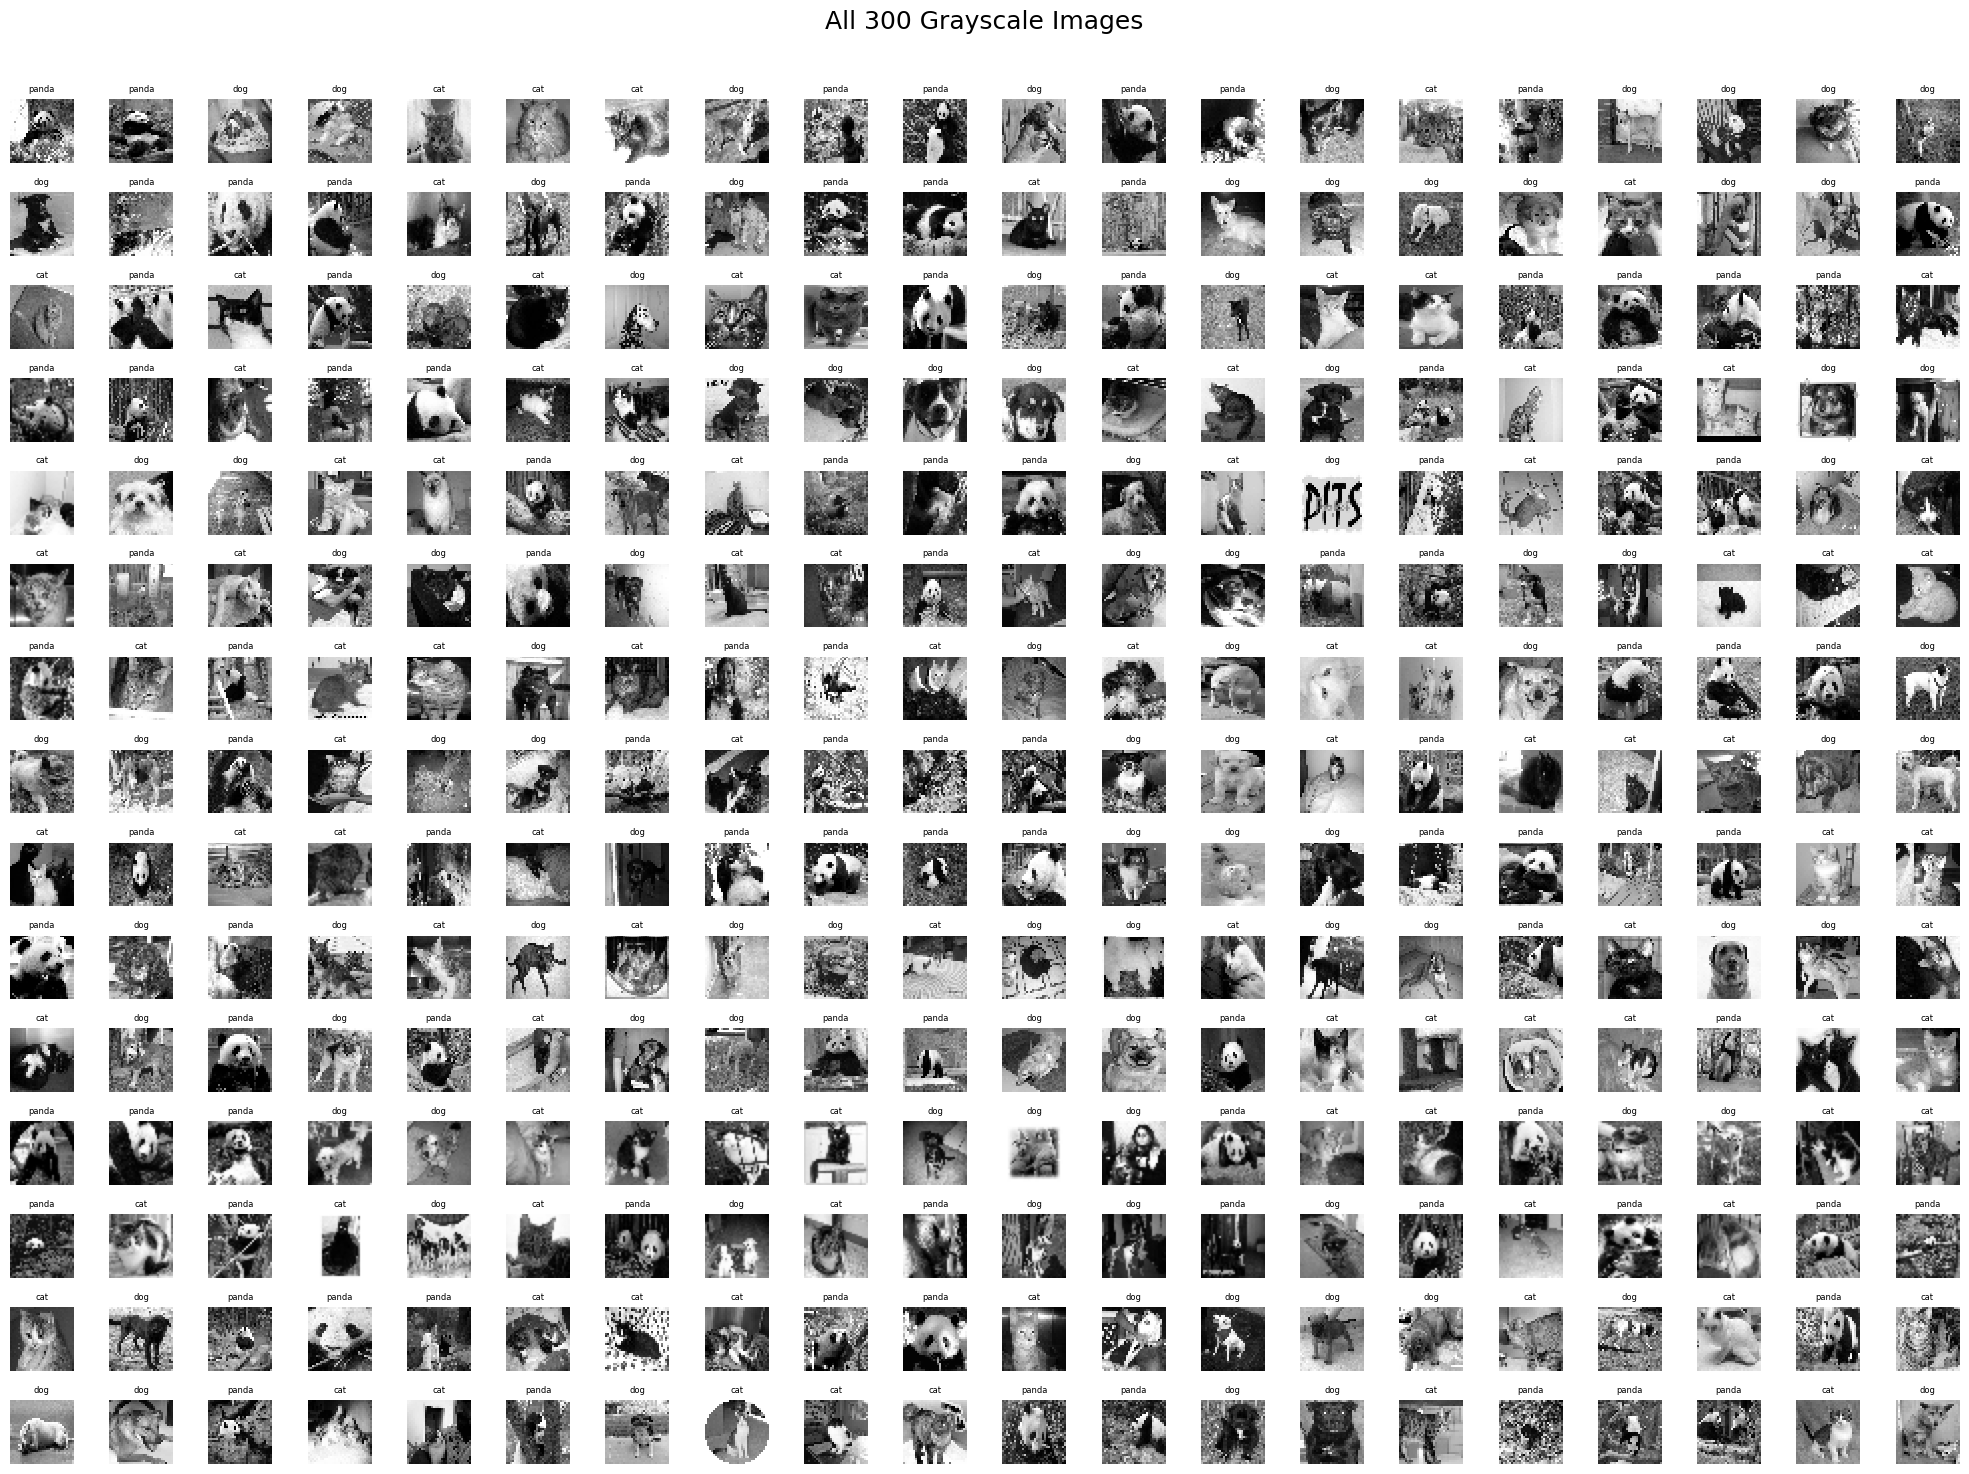

In [4]:
import matplotlib.pyplot as plt
import math

num_images = len(display_data)
if num_images == 0:
    print("No images to display!")
else:
    # Determine grid size
    cols = 20
    rows = math.ceil(num_images / cols)

    plt.figure(figsize=(20, rows))
    for i, (img, cls, name) in enumerate(display_data):
        plt.subplot(rows, cols, i+1)
        plt.imshow(img, cmap='gray')
        plt.title(cls, fontsize=6)
        plt.axis('off')

    plt.suptitle(f"All {num_images} Grayscale Images", fontsize=18)
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

**KNN Distance**

In [ ]:
from collections import Counter
import numpy as np

def manhattan_distance(a, b):
  
    return np.sum(np.abs(a - b))

def euclidean_distance(a, b):
   
    return np.sqrt(np.sum((a - b)**2))

def knn_predict(X_train, y_train, x_test, k=3, distance_type='L2'):
   
    if distance_type == 'L1':
        distances = np.sum(np.abs(X_train - x_test), axis=1)
    else:
        distances = np.sqrt(np.sum((X_train - x_test)**2, axis=1))

    k_indices = np.argsort(distances)[:k]
    k_labels = [y_train[i] for i in k_indices]

    # Majority vote
    most_common = Counter(k_labels).most_common(1)
    return most_common[0][0]


**5-Fold Cross-Validation**

Running 5-Fold CV for Manhattan (L1)...
Running 5-Fold CV for Euclidean (L2)...


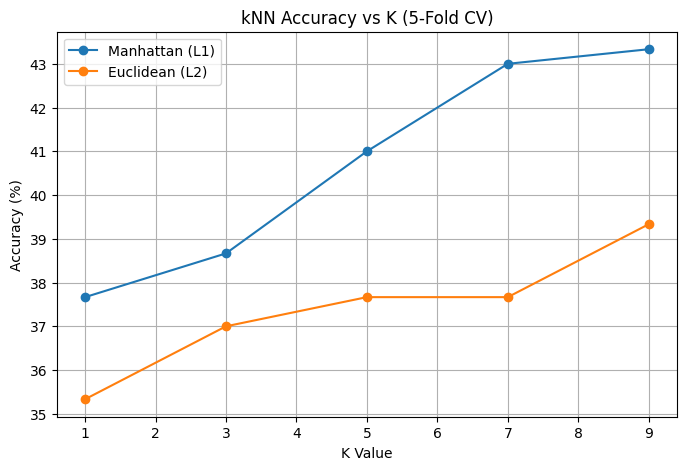

In [ ]:
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 

kf = KFold(n_splits=5, shuffle=True, random_state=42)
K_values = [1, 3, 5, 7, 9]

def cross_validate(features, labels, distance_type='L2'):

    avg_accuracies = []
    for k in K_values:
        fold_acc = []
        for train_idx, val_idx in kf.split(features):
            X_train, X_val = features[train_idx], features[val_idx]
            y_train, y_val = labels[train_idx], labels[val_idx]

            correct = 0
            for i in range(len(X_val)):
                pred = knn_predict(X_train, y_train, X_val[i], k=k, distance_type=distance_type)
                if pred == y_val[i]:
                    correct += 1
            fold_acc.append((correct / len(X_val)) * 100)

        avg_accuracies.append(np.mean(fold_acc))

    return avg_accuracies

print("Running 5-Fold CV for Manhattan (L1)...")
acc_L1 = cross_validate(features, labels, distance_type='L1')

print("Running 5-Fold CV for Euclidean (L2)...")
acc_L2 = cross_validate(features, labels, distance_type='L2')

plt.figure(figsize=(8,5))
plt.plot(K_values, acc_L1, 'o-', label="Manhattan (L1)")
plt.plot(K_values, acc_L2, 'o-', label="Euclidean (L2)")
plt.xlabel("K Value")
plt.ylabel("Accuracy (%)")
plt.title("kNN Accuracy vs K (5-Fold CV)")
plt.grid(True)
plt.legend()
plt.show()

**Top 5 Predictions**

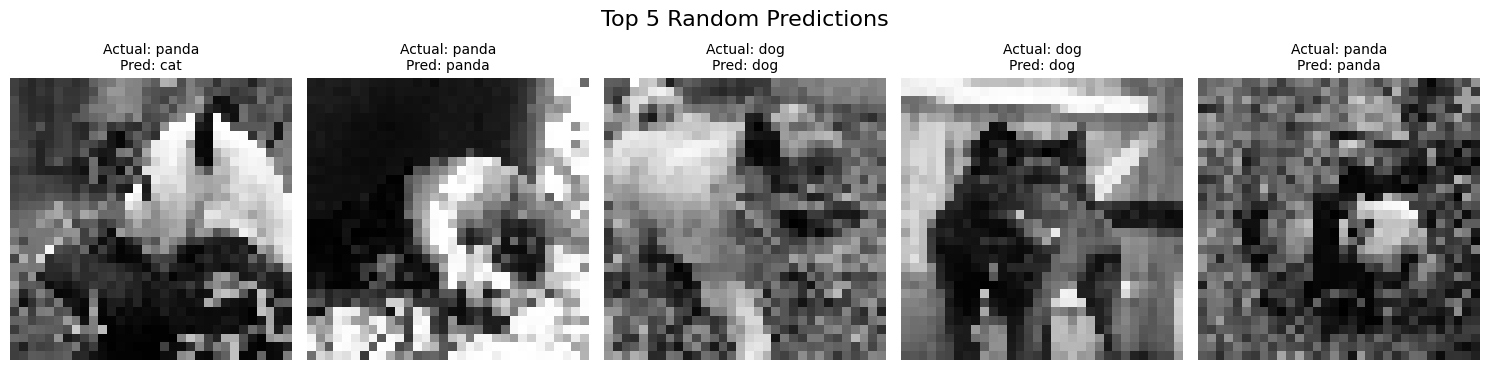

In [7]:
import random
import matplotlib.pyplot as plt
import numpy as np


random.seed(42)

plt.figure(figsize=(15,4))


indices = random.sample(range(len(features)), 5)

for i, idx in enumerate(indices):
    test_img = features[idx]
    test_label = labels[idx]
    pred_label = knn_predict(features, labels, test_img, k=3, distance_type='L2')

    plt.subplot(1, 5, i+1)
    plt.imshow(np.reshape(test_img, (IMG_SIZE, IMG_SIZE)), cmap='gray')
    plt.title(f"Actual: {test_label}\nPred: {pred_label}", fontsize=10)
    plt.axis('off')

plt.suptitle("Top 5 Random Predictions", fontsize=16)
plt.tight_layout()
plt.show()